In [1]:
# read a yaml file of reactions, check atom balance
# version using external routines
# also collect exptl data
# this version to produce JANAF-type table
import yaml, sys, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#sys.path.insert(0, '../../karlib')  # for gaussian_subs.py
sys.path.insert(0, '../../atomic_SOC')  # for chem_subs.py and molpro_subs.py
import chem_subs as chem
sys.path.insert(0, '../')  # for multirx_subs.py
import multirx_subs as mrx

In [2]:
target = 'cyrene'
T = 100.
Tref = 0  #  choose 0 or 298.15 to override the default

In [3]:
if Tref is None:
    if T not in [0, 298.15]:
        if abs(T) < abs(298.15 - T):
            # T is closer to 0 than to 298.15
            Tref = 0
        else:
            # T is closer to 298.15
            Tref = 298.15
    else:
        Tref = T
    print(f'Choosing Tref = {Tref}')
if T != Tref:
    print(f'EoF({target}) will be computed at T = {T} by adjustment from T = {Tref}')
else:
    print(f'EoF({target}) will be computed at T = {T}')    

EoF(cyrene) will be computed at T = 100.0 by adjustment from T = 0


In [4]:
dfrx, rxfmt = mrx.reaction_enthalpies_theor(target, Tref, fmt=True)

16 reactions for cyrene
All reactions are balanced
*** Warning: "No exptl data for cyrene" in select_expt()
*** Warning: "No SOC data for open-shell linear molecule o2" in compute_E0()


In [5]:
print(f'Reactions for {target} at T = {Tref}:')
display(dfrx.style.format(rxfmt))

Reactions for cyrene at T = 0:


,EoF,dH(rxn),uexp,Reaction,rho_T,rho_c,rho_E
0,-417.1,-1505.6,0.3,cyrene + 9/2 n2 = 6 hcn + no + 2 hno,14.3,0.8,1506.4
1,-414.2,-832.4,0.5,cyrene + 6 hcl = 3 c2h3cl + 3 hocl + h2,18.3,55.3,832.4
2,-412.1,-4.7,4.3,cyrene + cyc5 = dioxolane + bicyc82one,0.1,1.8,4.7
3,-410.3,-279.5,0.2,cyrene = 2 ketene + oxirane,0.2,65.6,279.5
4,-410.3,-106.3,0.2,cyrene + c2h2 = 3 ketene + c2h4,1.7,88.4,106.3
5,-409.2,706.9,0.2,cyrene + 11 h2 = 6 ch4 + 3 h2o,40.1,119.4,706.9
6,-407.7,2906.7,0.1,cyrene + 13/2 o2 = 6 co2 + 4 h2o,0.9,111.8,2906.7
7,-403.9,1.8,0.6,cyrene + ch4 + h2 + c3h8 = THP + DME + acetone,7.9,28.2,1.8
8,-403.7,21.7,0.8,cyrene + ch4 + h2 = dioxolane + MEK,8.0,33.4,21.7
9,-401.3,-485.8,0.3,cyrene + 3 h2o = 6 ch2o + h2,4.1,144.1,485.8


In [6]:
rho = 'rho_E'   # choose "rho_E" or "rho_T" or "rho_c"
wtg = 'nonuniform'  # choose "nonuniform" or "probabilistic"
#wtg = 'probabilistic'  # choose "nonuniform" or "probabilistic"

cyrene
"nonuniform" weighting using "rho_E"
Reference data at T = 0 K


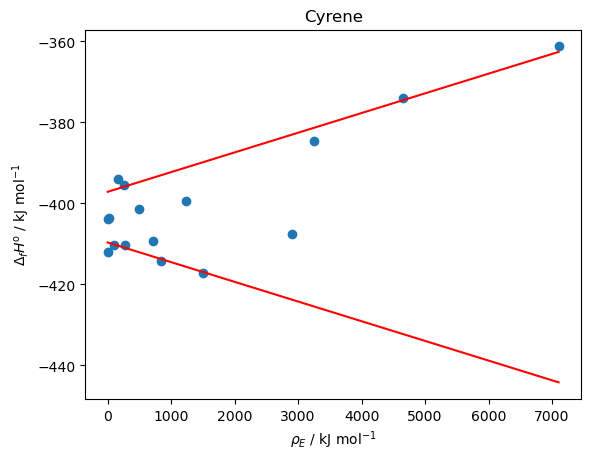

SEMw = 2.2, uexp = 1.2 kJ/mol
EoF(0.0 K) = (-403.4 ± 2.5) kJ/mol (standard uncertainty)


In [7]:
print(target)
print(f'"{wtg}" weighting using "{rho}"')
print(f'Reference data at T = {Tref} K')
# even if not requested, use non-uniform weighting to get guesses for probabilistic weighting
wmean, semw, rwmsx, a, b, change, niter = mrx.nonuniform_weighting(target, rho, dfrx,
                                                        verbose=False)
if wtg == 'probabilistic':
    parms, bstrap = mrx.probabilistic_weighting(target, rho, [wmean, a, b], dfrx, verbose=False)
    [H, sigma0, beta] = parms
    [stdH, Hvals, ttime] = bstrap
    mrx.plot_with_wedge(dfrx, target, rho, H, sigma0, beta)
    print('\tParameter bootstrapping took {:.0f} s to compute {:d} values for H\''.format(ttime, len(Hvals)))
    EoF_ref = H
    EoF_unc = stdH
else:
    # "nonuniform" weighting
    mrx.plot_with_wedge(dfrx, target, rho, wmean, a, b)
    # combine SEMw with u_exp
    print('SEMw = {:.1f}, uexp = {:.1f} kJ/mol'.format(semw, rwmsx))
    unc = np.sqrt(semw**2 + rwmsx**2)  # 'rwmsx' from eq. (13)
    EoF_ref = wmean
    EoF_unc = unc
print('EoF({:.1f} K) = ({:.1f} ± {:.1f}) kJ/mol (standard uncertainty)'.format(Tref, EoF_ref, EoF_unc))    

In [8]:
if T != Tref:
    print(f'Now adjusting EoF to the desired temperature = {T} K')
else:
    print('All done!')
    try:
        1/0
    except:
        pass

Now adjusting EoF to the desired temperature = 100.0 K


In [9]:
# Get interpolating functions and stoichiometric coefficients for relevant elements
fddH = {}
stoich = {}
mdata, Geom = mrx.read_molec_and_geom(target)
rx = mrx.reaction_to_elements(target, Geom)
for [mol, coeff] in rx:
    if mol == target:
        continue
    # all other educts should be elements
    df = mrx.read_reference_state_data(mol)
    fddH[mol] = chem.spline_fit(df['T(K)'], df['H-H(Tr)'])
    stoich[mol] = coeff

def elemcap(T):
    # Compute change in ddH across elements (uses globals)
    elddH = 0
    for elem, f in fddH.items():
        ddH_ref = f(Tref)
        ddH_targ = f(T)
        #print(elem, stoich[elem], f'{ddH_ref:.3f}, {ddH_targ:.3f}')
        elddH += stoich[elem] * (ddH_targ - ddH_ref)
    return elddH

elddH = elemcap(T)

In [10]:
# Get thermo data at reference temperature
mrx.thermo_functions(mdata, Tref, zpe_scale=0.98)
ddH_ref = mdata['thermo']['ddH']
# now at the desired temperature
mrx.thermo_functions(mdata, T, zpe_scale=0.98)
ddH_targ = mdata['thermo']['ddH']
ddH = ddH_targ['value'] - ddH_ref['value']  # change

In [11]:
# Enthalpy of formation of elements in standard states is defined to be zero at all temperatures
delta = ddH - elddH
print('Change in ddH from T = {} to T = {}:  target = {:.3f}, elements = {:.3f}, net = {:.3f}'.format(Tref, T, ddH, elddH, delta))
EoF = EoF_ref + delta
print()
print('*' * 60)
print('EoF({:.1f} K) = ({:.1f} ± {:.1f}) kJ/mol (standard uncertainty)'.format(T, EoF, EoF_unc))    
print('*' * 60)
print()
print(f'for "{target}" using "{wtg}" weighting and unreliability measure "{rho}"')

Change in ddH from T = 0 to T = 100.0:  target = 4.043, elements = 16.712, net = -12.669

************************************************************
EoF(100.0 K) = (-416.1 ± 2.5) kJ/mol (standard uncertainty)
************************************************************

for "cyrene" using "nonuniform" weighting and unreliability measure "rho_E"


In [12]:
# Prepare table of multiple temperatures
# list of temperatures
tlist = [298.15]
t = tmin = 0
tmax = 1000
tstep = 50
while t <= tmax:
    tlist.append(t)
    t += tstep
tlist.sort()
cols = ['T/K', 'EoF/(kJ/mol)', 'S/(J/K.mol)', 'Cp/(J/K.mol)', 'ddH/(kJ/mol)']
dfthermo = pd.DataFrame(columns=cols)
dfthermo['T/K'] = tlist
sl = []
cpl = []
ddhl = []
eofl = []
for T in tlist:
    mrx.thermo_functions(mdata, T, zpe_scale=0.98)
    ddH_targ = mdata['thermo']['ddH']
    ddhl.append(ddH_targ['value'])
    sl.append(mdata['thermo']['S']['value'])
    cpl.append(mdata['thermo']['S']['value'])
    elddH = elemcap(T)
    delta = (ddH_targ['value'] - ddH_ref['value']) - elddH
    EoF = EoF_ref + delta
    eofl.append(EoF)
dfthermo[cols[1]] = eofl
dfthermo[cols[2]] = sl
dfthermo[cols[3]] = cpl
dfthermo[cols[4]] = ddhl

In [13]:
# Round to reasonable precisions for display
fmt = {col: '{:.2f}' for col in cols}
fmt[cols[1]] = '{:.1f}'
display(dfthermo.style.format(fmt))
print(f'Estimated standard uncertainty for EoF is {EoF_unc:.1f} kJ/mol')
print(f'Reference temperature in calculations is {Tref} K')

,T/K,EoF/(kJ/mol),S/(J/K.mol),Cp/(J/K.mol),ddH/(kJ/mol)
0,0.00,-403.4,0.00,0.00,0.00
1,50.00,-410.1,230.32,230.32,1.75
2,100.00,-416.1,261.58,261.58,4.04
3,150.00,-421.4,285.46,285.46,7.01
4,200.00,-426.4,306.88,306.88,10.75
5,250.00,-431.3,327.52,327.52,15.40
6,298.15,-435.8,347.32,347.32,20.82
7,300.00,-435.9,348.08,348.08,21.05
8,350.00,-440.0,368.74,368.74,27.77
9,400.00,-443.7,389.43,389.43,35.52


Estimated standard uncertainty for EoF is 2.5 kJ/mol
Reference temperature in calculations is 0 K


### Below is for comparing results obtained using different reference temperatures

In [14]:
if Tref == 0:
    df0 = dfthermo.copy()
if Tref == 298.15:
    df298 = dfthermo.copy()

In [15]:
dfdiff = df298 - df0
dfdiff[cols[0]] = df0[cols[0]]
print('Differences in results, [T=298.15]-[T=0]')
display(dfdiff.style.format(fmt))

NameError: name 'df298' is not defined